In [178]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [179]:
IMAGE_PATH = "./diary.png"

#Open Image
image = image = Image.open(IMAGE_PATH)

#Convert image to numpy array
#Creates 3d array; Array of rows of pixels (and their rgb values)
img_arr = np.array(image, dtype=np.int32)
original_img_arr = np.array(image, dtype=np.uint8)

Make each row the avg color in black and white

In [180]:
for row in img_arr:
    R = 0
    G = 0
    B = 0
    for pixel in row:
        R = R + pixel[0]
        G = G + pixel[1]
        B = B + pixel[2]
    
    #Set every pixel to its average r g and b value
    avg_R = R/len(row)
    avg_G = G/len(row)
    avg_B = B/len(row)
    
    avg = (avg_R+avg_B+avg_G)/3
    
    for pixel in row:
        pixel[0] = avg
        pixel[1] = avg
        pixel[2] = avg

Convert back to image

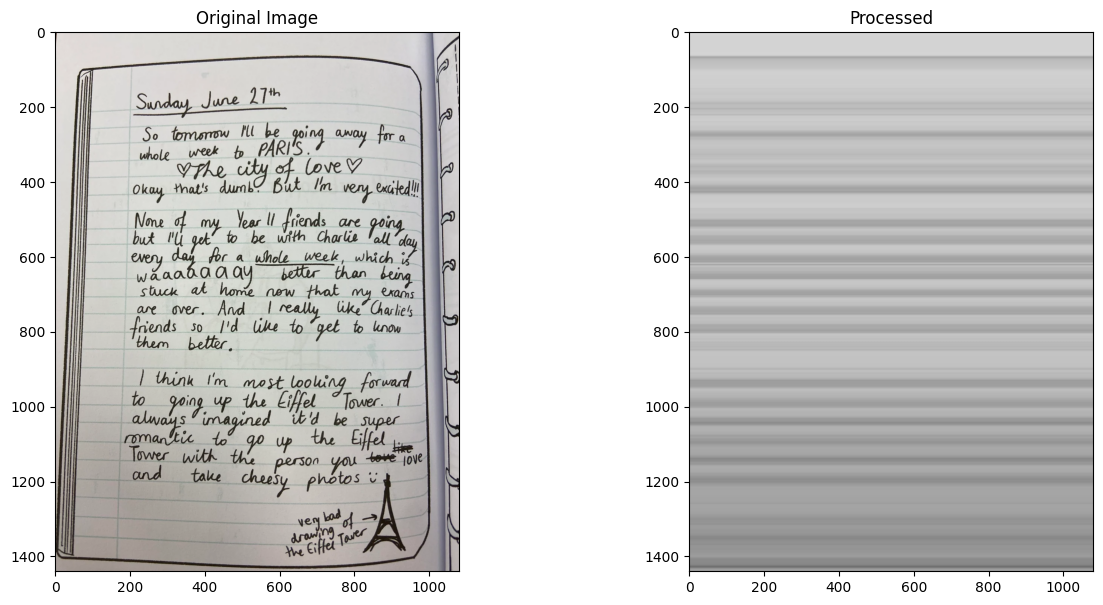

In [181]:
# Convert the processed array back to uint8 for pillow compatibility
formatted_img_arr = np.clip(img_arr, 0, 255).astype(np.uint8)

result_img = Image.fromarray(formatted_img_arr)

plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(image))
#plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(np.array(result_img))
#plt.axis('off')
plt.title("Processed")

plt.show()

Notice How you can see the line breaks. This might be useful when breaking up pages into chunks to feed into the AI

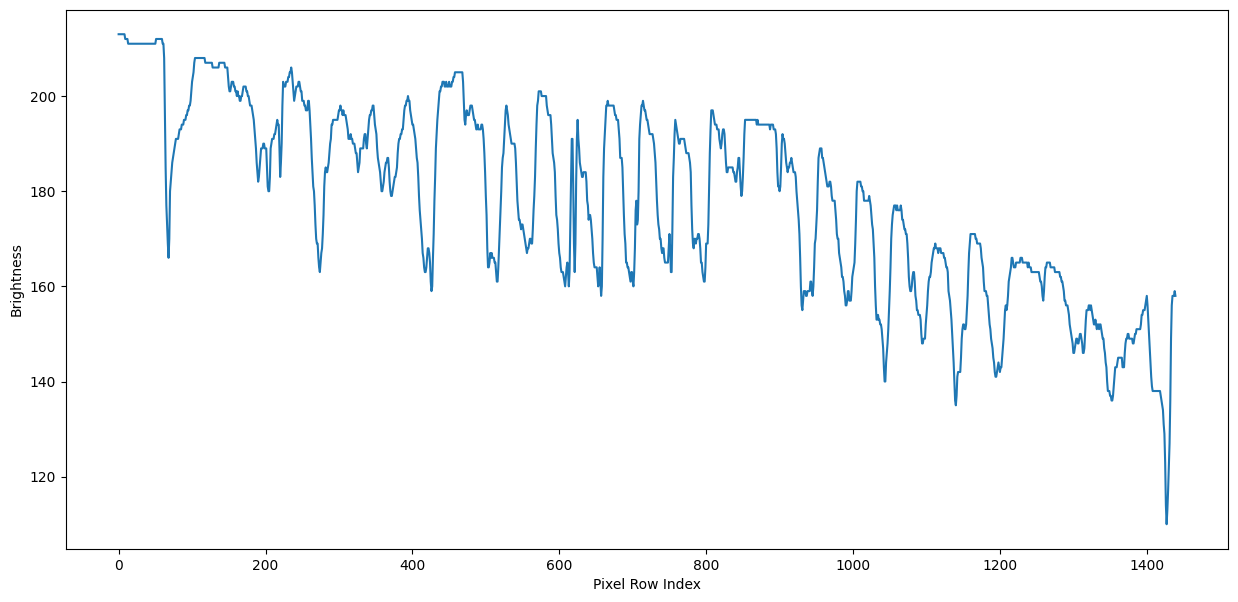

In [182]:
brightness = []

for row in img_arr:
    brightness.append(row[0][0])

plt.figure(figsize=(15, 7))
plt.plot(brightness)
plt.xlabel("Pixel Row Index")
plt.ylabel("Brightness")
plt.show()

In [183]:
# Find local maxima by checking where the second derivative is negative (change from positive to negative)
local_maxima_indices = (np.diff(np.sign(np.diff(brightness))) < 0).nonzero()[0] + 1

# Create a boolean array to mark local maxima
maxima_marks = np.zeros(len(brightness), dtype=bool)

# Threshold for considering a maximum as "larger"
threshold_factor = .9  # You can adjust this factor to detect only larger maxima

# Iterate over the local maxima indices
for idx in local_maxima_indices:
    if (idx > 0 and idx < len(brightness) - 1):
        # Compare the local maximum to its neighbors
        left_diff = brightness[idx] - brightness[idx - 1]
        right_diff = brightness[idx] - brightness[idx + 1]
        
        # Check if both neighbors are smaller than the current value by a threshold factor
        if left_diff > threshold_factor and right_diff > threshold_factor:
            maxima_marks[idx] = True

In [184]:
for i, row in enumerate(img_arr):
    if maxima_marks[i]:
        for pixel in row:
            pixel[0] = 255
            pixel[1] = 0
            pixel[2] = 0

for i, row in enumerate(original_img_arr):
    if maxima_marks[i]:
        for pixel in row:
            pixel[0] = 255
            pixel[1] = 0
            pixel[2] = 0
            

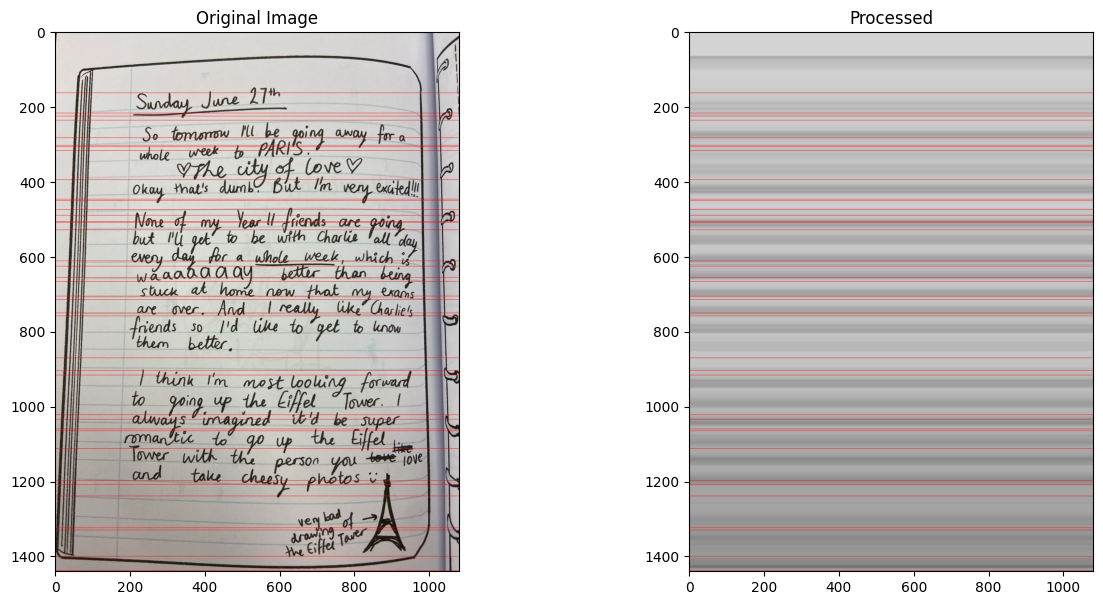

In [185]:
# Convert the processed array back to uint8 for pillow compatibility
formatted_img_arr = np.clip(img_arr, 0, 255).astype(np.uint8)

result_img = Image.fromarray(formatted_img_arr)
tweaked_img = Image.fromarray(original_img_arr)

plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(tweaked_img))
#plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(np.array(result_img))
#plt.axis('off')
plt.title("Processed")

plt.show()